In [1]:
import baostock as bs   
import pandas as pd

In [6]:
def get_all_k_data(startdate,enddate):
    """获得单个行业的所有股票数据
        :param startdate:起始日期
        :param enddate:截止日期
        :return:
    """
    lg = bs.login()
    print('login respond error_code:'+lg.error_code)
    print('login respond  error_msg:'+lg.error_msg)
    # 获取指定日期的指数、股票数据
    stock_rs = bs.query_stock_industry()
    industry_list = []
    while (stock_rs.error_code == '0') & stock_rs.next():
    # 获取一条记录，将记录合并在一起
        industry_list.append(stock_rs.get_row_data())
    stock_df = pd.DataFrame(industry_list, columns=stock_rs.fields)
    code_list = stock_df.loc[:,'code'].tolist()

    stock_klist = []
    for code in code_list:
        print("Downloading :" + code)
        k_rs = bs.query_history_k_data_plus(code, "date,code,open,high,low,close,preclose,volume,amount,pbMRQ,peTTM,turn,tradestatus,pctChg,isST", startdate, enddate)
        code_stocks = []
        while (k_rs.error_code == '0') & k_rs.next():
    # 获取一条记录，将记录合并在一起
            code_stocks.append(k_rs.get_row_data())
        stock_klist.extend(code_stocks)
    stock_df = pd.DataFrame(stock_klist,columns = k_rs.fields)
    bs.logout()
    return stock_df.sort_values(by=['code','date']) 

In [8]:
raw_mach_k = get_all_k_data('2022-01-01','2024-04-03')

login success!
login respond error_code:0
login respond  error_msg:success
logout success!


In [9]:
import numpy as np
def transform_df(mach_k):
    mach_k.loc[:,'n5_close'] = mach_k.groupby(['code'])['close'].shift(-5)
    cols = mach_k.columns[2:]
    mach_k.dropna(subset=['n5_close'],how='any',inplace=True)
    #mach_k.loc[:,cols] =  mach_k.loc[:,cols].replace('',np.nan)
    #mach_k.loc[:,cols] = mach_k.groupby('code')[cols].fillna(0)

    #mach_k.iloc[:,2:] = mach_k.iloc[:,2:].astype('float32')
    new_df = mach_k.loc[:,cols].apply(lambda x:pd.to_numeric(x,errors='coerce'))
    mach_k = pd.concat([mach_k.iloc[:,0:2],new_df],ignore_index=True,axis=1)
    new_cols = ['date','code']
    new_cols.extend(cols)
    mach_k.columns = new_cols
    mach_k.loc[:,cols] = mach_k.groupby('code')[cols].fillna(method='bfill')
    mach_k.loc[:,'gap_5d'] = (mach_k.loc[:,'n5_close']- mach_k.loc[:,'close'])/ mach_k.loc[:,'close']
    mach_k.loc[:,'is_inc_5d'] = mach_k.loc[:,'gap_5d'].apply(lambda x: 1 if x>=0.1 else 0)
    mach_k.loc[:,cols] = mach_k.groupby('code')[cols].fillna(0)
    return mach_k
mach_k = transform_df(raw_mach_k)
cat = 'all'
file_name = cat+'_stock.csv'

mach_k.to_csv(file_name,index=False)


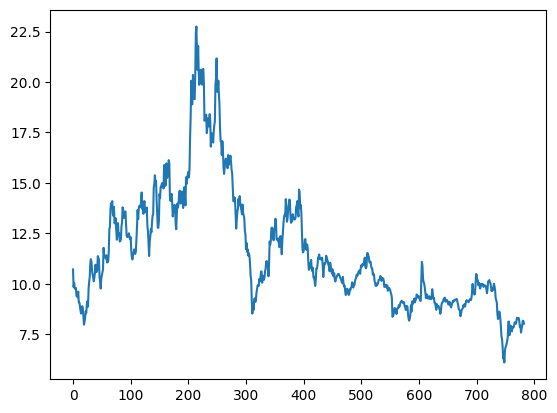

In [135]:
from matplotlib import pyplot as plt 
plt.plot(range(len(sdwd)),sdwd.loc[:,'close'])

In [22]:
inc_5d_num = mach_k.groupby('code')['is_inc_5d'].sum().sort_values(ascending=False)
mach_k.loc[:,'rnk'] = mach_k.groupby('code')['date'].rank(ascending=False)

rct_price = mach_k.loc[mach_k.loc[:,'rnk']==1,['code','close']]
rct_price.set_index('code',inplace=True)


In [23]:
df = pd.concat([inc_5d_num,rct_price],ignore_index=False,axis=1)

In [24]:
df.loc[df.loc[:,'close']<=10,:]

,is_inc_5d,close
code,,
sz.002336,88,9.89
sh.600303,78,3.99
sz.002642,74,6.29
sz.300081,73,7.02
sz.002316,73,4.21
...,...,...
sz.000501,0,7.28
sz.000585,0,0.36
sz.002202,0,7.33


In [21]:
mach_k.loc[mach_k.loc[:,'code']=='sh.603918',:].tail(10)

,date,code,open,high,low,close,preclose,volume,amount,pbMRQ,peTTM,turn,tradestatus,pctChg,isST,n5_close,gap_5d,is_inc_5d,rnk
824549,2022-01-04,sh.603918,9.03,9.77,9.03,9.62,9.11,23213093.0,2.193002e+08,3.280804,37.209417,6.3672,1,5.5982,0,8.68,-0.097713,0,1.0
824550,2022-01-05,sh.603918,9.62,9.71,9.23,9.32,9.62,14752070.0,1.385847e+08,3.178492,36.049040,4.0464,1,-3.1185,0,8.76,-0.060086,0,2.0
824551,2022-01-06,sh.603918,9.28,9.43,9.04,9.30,9.32,15920739.0,1.468316e+08,3.171672,35.971681,4.3670,1,-0.2146,0,8.64,-0.070968,0,3.0
824552,2022-01-07,sh.603918,9.58,9.73,9.00,9.04,9.30,18243566.0,1.696142e+08,3.083001,34.966021,5.0041,1,-2.7957,0,8.95,-0.009956,0,4.0
824553,2022-01-10,sh.603918,8.97,9.13,8.60,8.80,9.04,15090099.0,1.339526e+08,3.001152,34.037720,4.1391,1,-2.6549,0,9.43,0.071591,0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825084,2024-03-21,sh.603918,18.50,19.19,18.07,18.09,18.64,61206508.0,1.131853e+09,5.971166,242.672061,16.7126,1,-2.9506,0,15.90,-0.121061,0,536.0
825085,2024-03-22,sh.603918,17.94,18.20,17.26,17.75,18.09,33563320.0,5.944404e+08,5.858938,238.111060,9.1646,1,-1.8795,0,15.66,-0.117746,0,537.0
825086,2024-03-25,sh.603918,18.22,18.77,17.75,17.90,17.75,50525592.0,9.237221e+08,5.908451,240.123266,13.7962,1,0.8451,0,16.30,-0.089385,0,538.0
825087,2024-03-26,sh.603918,17.53,17.88,16.74,16.96,17.90,32012091.0,5.509313e+08,5.598174,227.513441,8.7410,1,-5.2514,0,16.04,-0.054245,0,539.0


In [166]:
pvt_mach = pd.pivot(mach_k,index=['date'],columns=['code'],values=['close'])

In [167]:
corr_mach = pvt_mach.corr()
from IPython.display import display
display(corr_mach)

close                                                    \
code            sh.600111 sh.600114 sh.600206 sh.600219 sh.600255 sh.600259   
      code                                                                    
close sh.600111  1.000000 -0.000203  0.633344  0.786778  0.402502  0.809085   
      sh.600114 -0.000203  1.000000 -0.197523 -0.066758 -0.132515 -0.058268   
      sh.600206  0.633344 -0.197523  1.000000  0.423615  0.612413  0.703196   
      sh.600219  0.786778 -0.066758  0.423615  1.000000  0.307469  0.666349   
      sh.600255  0.402502 -0.132515  0.612413  0.307469  1.000000  0.659825   
...                   ...       ...       ...       ...       ...       ...   
      sz.300855  0.822347 -0.195541  0.698053  0.669766  0.545211  0.754038   
      sz.300930  0.580481 -0.112633  0.655235  0.461480  0.712224  0.789559   
      sz.300963  0.530669 -0.337626  0.362405  0.758673  0.218332  0.475767   
      sz.300986  0.761980 -0.297729  0.542730  0.759188  0.523551  0.707868   
      sz.301026  0.894746 -0.106147  0.433798  0.923959  0.210585  0.690645   

                                                         ...            \
code            sh.600330 sh.600331 sh.600338 sh.600362  ... sz.300697   
      code                                               ...             
close sh.600111  0.724502 -0.060259  0.910067  0.309921  ...  0.065458   
      sh.600114  0.034826  0.655287 -0.070739 -0.088436  ... -0.096785   
      sh.600206  0.682479 -0.225623  0.733407 -0.057312  ... -0.095778   
      sh.600219  0.515373 -0.272343  0.688013  0.708541  ...  0.470094   
      sh.600255  0.615040 -0.361014  0.621922 -0.146713  ... -0.054734   
...                   ...       ...       ...       ...  ...       ...   
      sz.300855  0.820909 -0.388079  0.831034  0.159128  ...  0.014927   
      sz.300930  0.803166 -0.386481  0.704595  0.076041  ...  0.163678   
      sz.300963  0.320300 -0.563761  0.485784  0.767363  ...  0.720710   
      sz.300986  0.744836 -0.630025  0.772407  0.500660  ...  0.358830   
      sz.301026  0.592956 -0.243276  0.793176  0.832327  ...  0.702690   

                                                                             \
code            sz.300748 sz.300811 sz.300828 sz.300835 sz.300855 sz.300930   
      code                                                                    
close sh.600111  0.624431  0.548700  0.548808  0.631891  0.822347  0.580481   
      sh.600114 -0.283525 -0.156253 -0.129262 -0.016778 -0.195541 -0.112633   
      sh.600206  0.600875  0.643130  0.242265  0.276045  0.698053  0.655235   
      sh.600219  0.637513  0.312313  0.734458  0.746717  0.669766  0.461480   
      sh.600255  0.574408  0.649029  0.113910  0.247395  0.545211  0.712224   
...                   ...       ...       ...       ...       ...       ...   
      sz.300855  0.751507  0.753110  0.539680  0.631831  1.000000  0.674063   
      sz.300930  0.793225  0.653955  0.514183  0.562218  0.674063  1.000000   
      sz.300963  0.626724  0.234519  0.745479  0.648793  0.529361  0.416587   
      sz.300986  0.824838  0.615808  0.765214  0.824798  0.863961  0.634804   
      sz.301026  0.632242  0.364250  0.848008  0.813549  0.739055  0.458628   

                                               
code            sz.300963 sz.300986 sz.301026  
      code                                     
close sh.600111  0.530669  0.761980  0.894746  
      sh.600114 -0.337626 -0.297729 -0.106147  
      sh.600206  0.362405  0.542730  0.433798  
      sh.600219  0.758673  0.759188  0.923959  
      sh.600255  0.218332  0.523551  0.210585  
...                   ...       ...       ...  
      sz.300855  0.529361  0.863961  0.739055  
      sz.300930  0.416587  0.634804  0.458628  
      sz.300963  1.000000  0.765955  0.914466  
      sz.300986  0.765955  1.000000  0.779764  
      sz.301026  0.914466  0.779764  1.000000  

[135 rows x 135 columns]

In [168]:
corr_mach.loc[corr_mach.loc[:,('close','sz.002026')]< -0.5,('close','sz.002026')]

       code     
close  sh.600547   -0.524107
       sh.600766   -0.581894
       sz.000975   -0.622208
Name: (close, sz.002026), dtype: float64

### 使用神经网络预测未来5日增长的可能性

In [299]:
ts_cols = ['open','high','low','close','volume','amount','pbMRQ','peTTM','turn','pctChg']
sd_ts_features = sdwd.loc[:,ts_cols]
sd_cat_y = sdwd.loc[:,'is_inc_5d']
sd_ts_y = sdwd.loc[:,'gap_5d']

In [300]:
#prepare k data of one stock
p_inc = np.nan_to_num(sd_cat_y.values.reshape((-1,)))
raw_data = np.nan_to_num(sd_ts_features.values)

In [308]:
#compute the number of samples we will use for each data split
num_train_samples = int(0.5*len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_smaples = len(raw_data) - num_train_samples - num_val_samples

#normalize the data
meann = raw_data[:num_train_samples].mean(axis=0)
raw_data -= meann
stdd = raw_data[:num_train_samples].std(axis=0)
raw_data /= stdd



In [322]:
import keras
sequence_length = 120
batch_size = 64

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data,
    targets = p_inc,
    sequence_length=sequence_length,
    batch_size = batch_size,
    shuffle = True,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data,
    targets = p_inc,
    sequence_length=sequence_length,
    batch_size = batch_size,
    shuffle = True,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data,
    targets = p_inc,
    sequence_length=sequence_length,
    batch_size = batch_size,
    shuffle = True,
    start_index = num_train_samples + num_val_samples
)

In [323]:
for samples,targets in test_dataset:
    print('samples shape:',samples.shape)
    print("targets shape:",targets.shape)


samples shape: (64, 120, 10)
targets shape: (64,)
samples shape: (64, 120, 10)
targets shape: (64,)
samples shape: (64, 120, 10)
targets shape: (64,)
samples shape: (64, 120, 10)
targets shape: (64,)
samples shape: (4, 120, 10)
targets shape: (4,)


In [324]:
def evaluate_naive_method(dataset):
    total_abs_err = 0
    samples_seen = 0
    for samples,targets in dataset:
        preds = np.int64(samples[:,-1,1]*stdd[1] + meann[1])
        total_abs_err += np.sum(np.abs(preds-targets))
        samples_seen += samples.shape[0]

    return total_abs_err/samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 3.18
Test MAE: 0.72


In [325]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16,activation = 'relu')(x)
outputs = layers.Dense(1,activation ='sigmoid')(x)
model = keras.Model(inputs,outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="jena_dense.h5", save_best_only=True)
]
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_dense.h5")
print(f"Test accuracy:{model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10


10/10 [==============================] - 0s 8ms/step - loss: 0.2812 - accuracy: 0.9027 - val_loss: 1.6807 - val_accuracy: 0.3127
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.0788 - accuracy: 0.9717 - val_loss: 0.6326 - val_accuracy: 0.8147
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 0.0654 - accuracy: 0.9765 - val_loss: 1.7720 - val_accuracy: 0.2780
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 0.0678 - accuracy: 0.9780 - val_loss: 0.6382 - val_accuracy: 0.8185
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 0.0477 - accuracy: 0.9843 - val_loss: 0.6257 - val_accuracy: 0.8069
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.0402 - accuracy: 0.9796 - val_loss: 0.6212 - val_accuracy: 0.7375
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.0239 - accuracy: 0.9906 - val_loss: 0.7042 - val_accuracy: 0.7104
Epoch 8/10
10/10 [=============

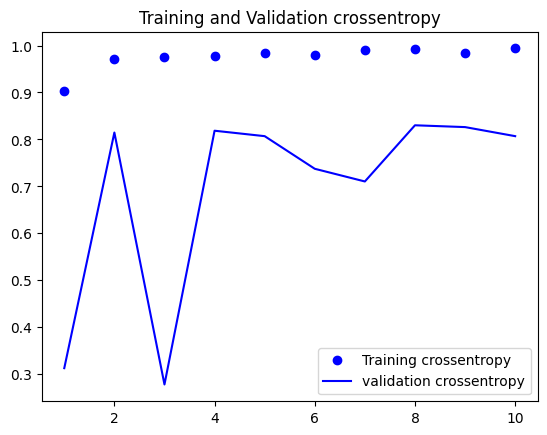

In [326]:
import matplotlib.pyplot as plt
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,"bo",label="Training crossentropy")
plt.plot(epochs, val_loss, "b",label = "validation crossentropy")
plt.title("Training and Validation crossentropy")
plt.legend()
plt.show()

In [327]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.Conv1D(8,15,activation='relu')(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8,10,activation='relu')(x)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8,5,activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1,activation='sigmoid')(x)

model = keras.Model(inputs,outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.h5",save_best_only=True)
]

model.compile(optimizer='rmsprop',loss="binary_crossentropy",metrics="accuracy")
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_conv.h5")
print(f"test accuracy: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
10/10 [==============================] - 0s 11ms/step - loss: 0.3368 - accuracy: 0.9608 - val_loss: 0.4881 - val_accuracy: 0.8263
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 0.1412 - accuracy: 0.9608 - val_loss: 0.4929 - val_accuracy: 0.8263
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.1301 - accuracy: 0.9608 - val_loss: 0.4913 - val_accuracy: 0.8263
Epoch 4/10


/Users/maxyang/miniconda3/envs/stockpy38/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 10ms/step - loss: 0.1258 - accuracy: 0.9608 - val_loss: 0.5370 - val_accuracy: 0.8263
Epoch 5/10
10/10 [==============================] - 0s 5ms/step - loss: 0.1227 - accuracy: 0.9608 - val_loss: 0.5148 - val_accuracy: 0.8263
Epoch 6/10
10/10 [==============================] - 0s 5ms/step - loss: 0.1213 - accuracy: 0.9608 - val_loss: 0.4929 - val_accuracy: 0.8263
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 0.1153 - accuracy: 0.9608 - val_loss: 0.4731 - val_accuracy: 0.8263
Epoch 8/10
10/10 [==============================] - 0s 6ms/step - loss: 0.1125 - accuracy: 0.9608 - val_loss: 0.4707 - val_accuracy: 0.8263
Epoch 9/10
10/10 [==============================] - 0s 6ms/step - loss: 0.1114 - accuracy: 0.9608 - val_loss: 0.4642 - val_accuracy: 0.8263
Epoch 10/10
5/5 [==============================] - 0s 1ms/step - loss: 0.1507 - accuracy: 0.9692
test accuracy: 0.97


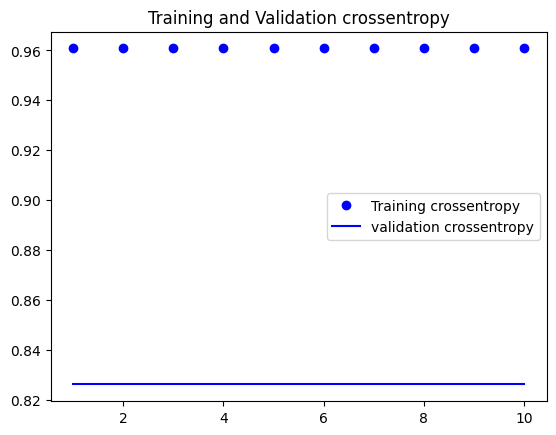

In [328]:
import matplotlib.pyplot as plt
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,"bo",label="Training crossentropy")
plt.plot(epochs, val_loss, "b",label = "validation crossentropy")
plt.title("Training and Validation crossentropy")
plt.legend()
plt.show()

In [331]:
inputs = keras.Input(shape = (sequence_length,raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs,outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.h5")
print(f"Test lstm accuracy:{model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
10/10 [==============================] - 1s 30ms/step - loss: 0.6356 - accuracy: 0.7253 - val_loss: 0.6274 - val_accuracy: 0.8224
Epoch 2/10
10/10 [==============================] - 0s 14ms/step - loss: 0.5034 - accuracy: 0.9403 - val_loss: 0.6655 - val_accuracy: 0.6100
Epoch 3/10
10/10 [==============================] - 0s 14ms/step - loss: 0.3876 - accuracy: 0.9608 - val_loss: 0.6963 - val_accuracy: 0.4749
Epoch 4/10
10/10 [==============================] - 0s 14ms/step - loss: 0.2873 - accuracy: 0.9608 - val_loss: 0.7874 - val_accuracy: 0.3861
Epoch 5/10
10/10 [==============================] - 0s 14ms/step - loss: 0.2167 - accuracy: 0.9608 - val_loss: 0.6816 - val_accuracy: 0.4749
Epoch 6/10
10/10 [==============================] - 0s 14ms/step - loss: 0.1768 - accuracy: 0.9608 - val_loss: 0.6410 - val_accuracy: 0.5560
Epoch 7/10
10/10 [==============================] - 0s 15ms/step - loss: 0.1572 - accuracy: 0.9608 - val_loss: 0.5652 - val_accuracy: 0.7606
Epoch 8/10
10

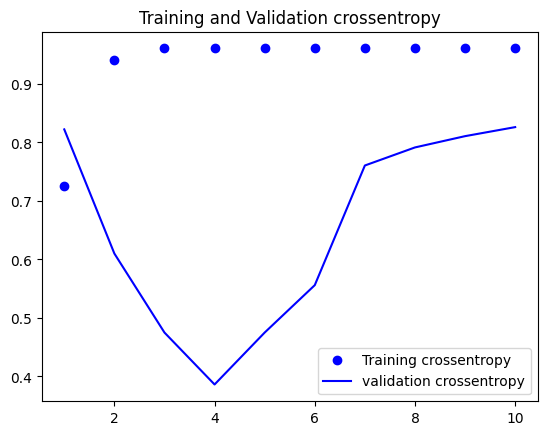

In [332]:
import matplotlib.pyplot as plt
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,"bo",label="Training crossentropy")
plt.plot(epochs, val_loss, "b",label = "validation crossentropy")
plt.title("Training and Validation crossentropy")
plt.legend()
plt.show()